In [1]:
from typing import Tuple, Optional, Union
import math
import torch as th
import torch
import torch.nn as nn
import torchaudio as ta
from torchaudio.transforms import PSD
import torch.nn.functional as F

from Modules import STFT, mask_estimator
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import Dataset
import os
torch.manual_seed(0)

def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise

class my_dataset(Dataset):
    def __init__(self, path):
        self.path_signal = os.listdir(f'{path}/mic')
        self.path_target = f'{path}/target'
        self.path_mic = f'{path}/mic'
        self.noise = torch.rand(1,53768)
        
    def __len__(self):
        return len(self.path_signal)
    
    def __getitem__(self, idx):
        path = self.path_signal[0]
        
        target, sample_rate = ta.load(f'{self.path_target}/{path}')
        mic_array, sample_rate = ta.load(f'{self.path_mic}/{path}')
        
        target = F.pad(target, (0, mic_array.shape[-1] - target.shape[-1]))
        return  target, generate_mixture(target, self.noise, -10), mic_array

In [3]:
data_train = my_dataset('./beam_data/train')

In [4]:
train_target = data_train[0][0]
train_sample = data_train[0][1]

In [5]:
model_mask = mask_estimator()

In [6]:
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

In [7]:
from IPython.display import Audio
Audio(train_sample, rate=16000)

In [8]:
from tqdm import tqdm
from torchvision.utils import make_grid
from torchmetrics import ScaleInvariantSignalNoiseRatio

epochs = 1000

optim = torch.optim.Adam(model_mask.parameters(), lr=3e-4)


si = ScaleInvariantSignalNoiseRatio()
losses = []
metrics = []

for epoch in tqdm(range(epochs)):
    optim.zero_grad()
    
    spec_sample = stft.stft(train_sample[None])
    mag = spec_sample.abs().mean(dim=1)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

    mask = model_mask(spec_sample)
    mag_predict = mag * mask

    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, train_sample.shape[-1])
    loss = F.mse_loss(wave_predict, train_target[None])
    
    loss.backward()
    optim.step()
    
    metrics.append(si(wave_predict.detach(), train_target))
    losses.append(loss.item())
    print("Epoch [{}/{}], loss: {:.4f}, metric: {:.4f}".format(epoch+1, epochs, losses[-1], metrics[-1]))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Максим\AppData\Local\Temp\ipykernel_10676\3807900989.py:27: UserWarning: Using a target size (torch.Size([1, 1, 53768])) that is different to the input size (torch.Size([1, 53768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(wave_predict, train_target[None])
  0%|▏                                                                                | 2/1000 [00:00<00:57, 17.25it/s]

Epoch [1/1000], loss: 0.0094, metric: -3.2059
Epoch [2/1000], loss: 0.0069, metric: -3.2391
Epoch [3/1000], loss: 0.0051, metric: -3.2655
Epoch [4/1000], loss: 0.0040, metric: -3.2621
Epoch [5/1000], loss: 0.0034, metric: -3.2103


  1%|▌                                                                                | 7/1000 [00:00<00:56, 17.53it/s]

Epoch [6/1000], loss: 0.0031, metric: -3.1035
Epoch [7/1000], loss: 0.0028, metric: -2.9449
Epoch [8/1000], loss: 0.0026, metric: -2.7463
Epoch [9/1000], loss: 0.0025, metric: -2.5195


  1%|▉                                                                               | 11/1000 [00:00<00:58, 16.81it/s]

Epoch [10/1000], loss: 0.0024, metric: -2.2736
Epoch [11/1000], loss: 0.0023, metric: -2.0167
Epoch [12/1000], loss: 0.0022, metric: -1.7552
Epoch [13/1000], loss: 0.0021, metric: -1.4938


  2%|█▎                                                                              | 16/1000 [00:00<00:53, 18.26it/s]

Epoch [14/1000], loss: 0.0020, metric: -1.2350
Epoch [15/1000], loss: 0.0020, metric: -0.9831
Epoch [16/1000], loss: 0.0019, metric: -0.7401
Epoch [17/1000], loss: 0.0018, metric: -0.5062


  2%|█▌                                                                              | 20/1000 [00:01<00:55, 17.76it/s]

Epoch [18/1000], loss: 0.0018, metric: -0.2842
Epoch [19/1000], loss: 0.0017, metric: -0.0749
Epoch [20/1000], loss: 0.0017, metric: 0.1214
Epoch [21/1000], loss: 0.0016, metric: 0.3067



  2%|█▊                                                                              | 23/1000 [00:01<00:53, 18.31it/s]

Epoch [22/1000], loss: 0.0016, metric: 0.4788
Epoch [23/1000], loss: 0.0016, metric: 0.6404
Epoch [24/1000], loss: 0.0015, metric: 0.7900
Epoch [25/1000], loss: 0.0015, metric: 0.9302


  3%|██▏                                                                             | 28/1000 [00:01<00:50, 19.17it/s]

Epoch [26/1000], loss: 0.0015, metric: 1.0600
Epoch [27/1000], loss: 0.0014, metric: 1.1800
Epoch [28/1000], loss: 0.0014, metric: 1.2925
Epoch [29/1000], loss: 0.0014, metric: 1.3967


  3%|██▋                                                                             | 33/1000 [00:01<00:50, 19.23it/s]

Epoch [30/1000], loss: 0.0014, metric: 1.4935
Epoch [31/1000], loss: 0.0014, metric: 1.5834
Epoch [32/1000], loss: 0.0013, metric: 1.6680
Epoch [33/1000], loss: 0.0013, metric: 1.7472
Epoch [34/1000], loss: 0.0013, metric: 1.8230


  4%|███                                                                             | 38/1000 [00:02<00:51, 18.71it/s]

Epoch [35/1000], loss: 0.0013, metric: 1.8948
Epoch [36/1000], loss: 0.0013, metric: 1.9644
Epoch [37/1000], loss: 0.0013, metric: 2.0324
Epoch [38/1000], loss: 0.0013, metric: 2.0991



  4%|███▎                                                                            | 41/1000 [00:02<00:49, 19.45it/s]

Epoch [39/1000], loss: 0.0013, metric: 2.1644
Epoch [40/1000], loss: 0.0013, metric: 2.2287
Epoch [41/1000], loss: 0.0012, metric: 2.2921
Epoch [42/1000], loss: 0.0012, metric: 2.3560
Epoch [43/1000], loss: 0.0012, metric: 2.4211


  5%|███▊                                                                            | 47/1000 [00:02<00:52, 18.24it/s]

Epoch [44/1000], loss: 0.0012, metric: 2.4871
Epoch [45/1000], loss: 0.0012, metric: 2.5535
Epoch [46/1000], loss: 0.0012, metric: 2.6202
Epoch [47/1000], loss: 0.0012, metric: 2.6886


  5%|████                                                                            | 51/1000 [00:02<00:53, 17.85it/s]

Epoch [48/1000], loss: 0.0012, metric: 2.7586
Epoch [49/1000], loss: 0.0012, metric: 2.8282
Epoch [50/1000], loss: 0.0012, metric: 2.8984
Epoch [51/1000], loss: 0.0012, metric: 2.9684



  5%|████▏                                                                           | 53/1000 [00:02<00:53, 17.82it/s]

Epoch [52/1000], loss: 0.0012, metric: 3.0343
Epoch [53/1000], loss: 0.0012, metric: 3.0951
Epoch [54/1000], loss: 0.0012, metric: 3.1527
Epoch [55/1000], loss: 0.0012, metric: 3.2063
Epoch [56/1000], loss: 0.0012, metric: 3.2521


  6%|████▋                                                                           | 58/1000 [00:03<00:49, 18.86it/s]

Epoch [57/1000], loss: 0.0011, metric: 3.2932
Epoch [58/1000], loss: 0.0011, metric: 3.3300
Epoch [59/1000], loss: 0.0011, metric: 3.3628
Epoch [60/1000], loss: 0.0011, metric: 3.3879


  6%|█████                                                                           | 63/1000 [00:03<00:51, 18.10it/s]

Epoch [61/1000], loss: 0.0011, metric: 3.4059
Epoch [62/1000], loss: 0.0011, metric: 3.4178
Epoch [63/1000], loss: 0.0011, metric: 3.4294
Epoch [64/1000], loss: 0.0011, metric: 3.4369


  7%|█████▎                                                                          | 67/1000 [00:03<00:53, 17.45it/s]

Epoch [65/1000], loss: 0.0011, metric: 3.4416
Epoch [66/1000], loss: 0.0011, metric: 3.4441
Epoch [67/1000], loss: 0.0011, metric: 3.4506
Epoch [68/1000], loss: 0.0011, metric: 3.4619


  7%|█████▊                                                                          | 72/1000 [00:03<00:52, 17.82it/s]

Epoch [69/1000], loss: 0.0011, metric: 3.4785
Epoch [70/1000], loss: 0.0011, metric: 3.4951
Epoch [71/1000], loss: 0.0011, metric: 3.5118
Epoch [72/1000], loss: 0.0011, metric: 3.5333


  8%|██████                                                                          | 76/1000 [00:04<00:53, 17.40it/s]

Epoch [73/1000], loss: 0.0011, metric: 3.5596
Epoch [74/1000], loss: 0.0011, metric: 3.5890
Epoch [75/1000], loss: 0.0011, metric: 3.6169
Epoch [76/1000], loss: 0.0011, metric: 3.6421



  8%|██████▏                                                                         | 78/1000 [00:04<00:51, 17.99it/s]

Epoch [77/1000], loss: 0.0011, metric: 3.6637
Epoch [78/1000], loss: 0.0011, metric: 3.6844
Epoch [79/1000], loss: 0.0011, metric: 3.7041
Epoch [80/1000], loss: 0.0011, metric: 3.7228


  8%|██████▋                                                                         | 83/1000 [00:04<00:53, 17.12it/s]

Epoch [81/1000], loss: 0.0011, metric: 3.7411
Epoch [82/1000], loss: 0.0010, metric: 3.7597
Epoch [83/1000], loss: 0.0010, metric: 3.7815



  8%|██████▊                                                                         | 85/1000 [00:04<00:56, 16.33it/s]

Epoch [84/1000], loss: 0.0010, metric: 3.8030
Epoch [85/1000], loss: 0.0010, metric: 3.8246
Epoch [86/1000], loss: 0.0010, metric: 3.8470
Epoch [87/1000], loss: 0.0010, metric: 3.8706


  9%|███████                                                                         | 89/1000 [00:04<00:57, 15.94it/s]

Epoch [88/1000], loss: 0.0010, metric: 3.8955
Epoch [89/1000], loss: 0.0010, metric: 3.9208
Epoch [90/1000], loss: 0.0010, metric: 3.9523
Epoch [91/1000], loss: 0.0010, metric: 3.9799


 10%|███████▌                                                                        | 95/1000 [00:05<00:53, 17.05it/s]

Epoch [92/1000], loss: 0.0010, metric: 4.0016
Epoch [93/1000], loss: 0.0010, metric: 4.0226
Epoch [94/1000], loss: 0.0010, metric: 4.0362
Epoch [95/1000], loss: 0.0010, metric: 4.0436



 10%|███████▊                                                                        | 97/1000 [00:05<00:54, 16.65it/s]

Epoch [96/1000], loss: 0.0010, metric: 4.0470
Epoch [97/1000], loss: 0.0010, metric: 4.0542
Epoch [98/1000], loss: 0.0010, metric: 4.0650
Epoch [99/1000], loss: 0.0010, metric: 4.0871


 10%|████████                                                                       | 102/1000 [00:05<00:49, 18.09it/s]

Epoch [100/1000], loss: 0.0010, metric: 4.1125
Epoch [101/1000], loss: 0.0010, metric: 4.1404
Epoch [102/1000], loss: 0.0010, metric: 4.1635
Epoch [103/1000], loss: 0.0010, metric: 4.1800


 11%|████████▍                                                                      | 107/1000 [00:05<00:49, 18.06it/s]

Epoch [104/1000], loss: 0.0010, metric: 4.1914
Epoch [105/1000], loss: 0.0010, metric: 4.2033
Epoch [106/1000], loss: 0.0010, metric: 4.2257
Epoch [107/1000], loss: 0.0010, metric: 4.2516



 11%|████████▌                                                                      | 109/1000 [00:06<00:52, 16.84it/s]

Epoch [108/1000], loss: 0.0010, metric: 4.2760
Epoch [109/1000], loss: 0.0010, metric: 4.2904
Epoch [110/1000], loss: 0.0010, metric: 4.2985
Epoch [111/1000], loss: 0.0010, metric: 4.3112


 12%|█████████                                                                      | 115/1000 [00:06<00:44, 19.88it/s]

Epoch [112/1000], loss: 0.0010, metric: 4.3300
Epoch [113/1000], loss: 0.0009, metric: 4.3432
Epoch [114/1000], loss: 0.0009, metric: 4.3513
Epoch [115/1000], loss: 0.0009, metric: 4.3565
Epoch [116/1000], loss: 0.0009, metric: 4.3714



 12%|█████████▎                                                                     | 118/1000 [00:06<00:45, 19.47it/s]

Epoch [117/1000], loss: 0.0009, metric: 4.3878
Epoch [118/1000], loss: 0.0009, metric: 4.4039
Epoch [119/1000], loss: 0.0009, metric: 4.4212
Epoch [120/1000], loss: 0.0009, metric: 4.4605


 12%|█████████▋                                                                     | 123/1000 [00:06<00:46, 18.93it/s]

Epoch [121/1000], loss: 0.0009, metric: 4.4870
Epoch [122/1000], loss: 0.0009, metric: 4.5140
Epoch [123/1000], loss: 0.0009, metric: 4.5581
Epoch [124/1000], loss: 0.0009, metric: 4.5688


 13%|██████████                                                                     | 128/1000 [00:07<00:44, 19.72it/s]

Epoch [125/1000], loss: 0.0009, metric: 4.6289
Epoch [126/1000], loss: 0.0009, metric: 4.6404
Epoch [127/1000], loss: 0.0009, metric: 4.6829
Epoch [128/1000], loss: 0.0009, metric: 4.7317
Epoch [129/1000], loss: 0.0009, metric: 4.7457


 13%|██████████▌                                                                    | 133/1000 [00:07<00:44, 19.60it/s]

Epoch [130/1000], loss: 0.0009, metric: 4.7910
Epoch [131/1000], loss: 0.0009, metric: 4.8272
Epoch [132/1000], loss: 0.0009, metric: 4.8414
Epoch [133/1000], loss: 0.0009, metric: 4.9042


 14%|██████████▊                                                                    | 137/1000 [00:07<00:47, 18.26it/s]

Epoch [134/1000], loss: 0.0009, metric: 4.8698
Epoch [135/1000], loss: 0.0009, metric: 4.9586
Epoch [136/1000], loss: 0.0009, metric: 4.9662
Epoch [137/1000], loss: 0.0009, metric: 4.9162



 14%|██████████▉                                                                    | 139/1000 [00:07<00:48, 17.88it/s]

Epoch [138/1000], loss: 0.0009, metric: 5.0114
Epoch [139/1000], loss: 0.0009, metric: 5.0293
Epoch [140/1000], loss: 0.0008, metric: 5.0170
Epoch [141/1000], loss: 0.0008, metric: 5.0004


 14%|███████████▎                                                                   | 143/1000 [00:07<00:49, 17.28it/s]

Epoch [142/1000], loss: 0.0008, metric: 5.0772
Epoch [143/1000], loss: 0.0008, metric: 5.1255
Epoch [144/1000], loss: 0.0008, metric: 5.1258
Epoch [145/1000], loss: 0.0008, metric: 5.0921


 15%|███████████▋                                                                   | 148/1000 [00:08<00:47, 18.08it/s]

Epoch [146/1000], loss: 0.0008, metric: 5.1319
Epoch [147/1000], loss: 0.0008, metric: 5.1723
Epoch [148/1000], loss: 0.0008, metric: 5.1240
Epoch [149/1000], loss: 0.0008, metric: 5.1393


 15%|████████████                                                                   | 153/1000 [00:08<00:45, 18.55it/s]

Epoch [150/1000], loss: 0.0008, metric: 5.2142
Epoch [151/1000], loss: 0.0008, metric: 5.2426
Epoch [152/1000], loss: 0.0008, metric: 5.2552
Epoch [153/1000], loss: 0.0008, metric: 5.2468



 16%|████████████▏                                                                  | 155/1000 [00:08<00:48, 17.50it/s]

Epoch [154/1000], loss: 0.0008, metric: 5.2408
Epoch [155/1000], loss: 0.0008, metric: 5.3000
Epoch [156/1000], loss: 0.0008, metric: 5.3385
Epoch [157/1000], loss: 0.0008, metric: 5.3600


 16%|████████████▌                                                                  | 159/1000 [00:08<00:47, 17.66it/s]

Epoch [158/1000], loss: 0.0008, metric: 5.3549
Epoch [159/1000], loss: 0.0008, metric: 5.3399
Epoch [160/1000], loss: 0.0008, metric: 5.3727
Epoch [161/1000], loss: 0.0008, metric: 5.3736


 16%|████████████▉                                                                  | 164/1000 [00:09<00:46, 17.81it/s]

Epoch [162/1000], loss: 0.0008, metric: 5.3575
Epoch [163/1000], loss: 0.0008, metric: 5.3284
Epoch [164/1000], loss: 0.0008, metric: 5.3596
Epoch [165/1000], loss: 0.0008, metric: 5.4096
Epoch [166/1000], loss: 0.0008, metric: 5.4627


 17%|█████████████▍                                                                 | 170/1000 [00:09<00:42, 19.61it/s]

Epoch [167/1000], loss: 0.0008, metric: 5.5059
Epoch [168/1000], loss: 0.0008, metric: 5.5329
Epoch [169/1000], loss: 0.0008, metric: 5.5674
Epoch [170/1000], loss: 0.0008, metric: 5.5747



 17%|█████████████▌                                                                 | 172/1000 [00:09<00:43, 18.94it/s]

Epoch [171/1000], loss: 0.0008, metric: 5.5576
Epoch [172/1000], loss: 0.0008, metric: 5.5410
Epoch [173/1000], loss: 0.0008, metric: 5.5723
Epoch [174/1000], loss: 0.0008, metric: 5.6057


 18%|██████████████                                                                 | 178/1000 [00:09<00:43, 18.76it/s]

Epoch [175/1000], loss: 0.0008, metric: 5.6280
Epoch [176/1000], loss: 0.0008, metric: 5.6265
Epoch [177/1000], loss: 0.0008, metric: 5.6215
Epoch [178/1000], loss: 0.0008, metric: 5.5814


 18%|██████████████▍                                                                | 182/1000 [00:10<00:45, 17.92it/s]

Epoch [179/1000], loss: 0.0008, metric: 5.5514
Epoch [180/1000], loss: 0.0008, metric: 5.5925
Epoch [181/1000], loss: 0.0008, metric: 5.6792
Epoch [182/1000], loss: 0.0008, metric: 5.7511



 18%|██████████████▌                                                                | 184/1000 [00:10<00:47, 17.32it/s]

Epoch [183/1000], loss: 0.0008, metric: 5.7886
Epoch [184/1000], loss: 0.0008, metric: 5.7688
Epoch [185/1000], loss: 0.0008, metric: 5.7320
Epoch [186/1000], loss: 0.0008, metric: 5.7250


 19%|███████████████                                                                | 190/1000 [00:10<00:48, 16.75it/s]

Epoch [187/1000], loss: 0.0008, metric: 5.7456
Epoch [188/1000], loss: 0.0008, metric: 5.7730
Epoch [189/1000], loss: 0.0009, metric: 5.2959
Epoch [190/1000], loss: 0.0009, metric: 4.7011


 19%|███████████████▎                                                               | 194/1000 [00:10<00:46, 17.29it/s]

Epoch [191/1000], loss: 0.0009, metric: 4.5037
Epoch [192/1000], loss: 0.0009, metric: 4.4677
Epoch [193/1000], loss: 0.0009, metric: 4.6240
Epoch [194/1000], loss: 0.0009, metric: 4.9314


 20%|███████████████▋                                                               | 198/1000 [00:10<00:44, 18.08it/s]

Epoch [195/1000], loss: 0.0008, metric: 5.2007
Epoch [196/1000], loss: 0.0009, metric: 5.3062
Epoch [197/1000], loss: 0.0009, metric: 5.3570
Epoch [198/1000], loss: 0.0008, metric: 5.3790
Epoch [199/1000], loss: 0.0008, metric: 5.3145



 20%|███████████████▉                                                               | 201/1000 [00:11<00:42, 18.81it/s]

Epoch [200/1000], loss: 0.0008, metric: 5.2116
Epoch [201/1000], loss: 0.0008, metric: 5.1803
Epoch [202/1000], loss: 0.0008, metric: 5.2697
Epoch [203/1000], loss: 0.0008, metric: 5.4444


 20%|████████████████▏                                                              | 205/1000 [00:11<00:50, 15.86it/s]

Epoch [204/1000], loss: 0.0008, metric: 5.6203
Epoch [205/1000], loss: 0.0008, metric: 5.7392
Epoch [206/1000], loss: 0.0008, metric: 5.7859



 21%|████████████████▎                                                              | 207/1000 [00:11<00:55, 14.41it/s]

Epoch [207/1000], loss: 0.0008, metric: 5.7840
Epoch [208/1000], loss: 0.0008, metric: 5.7924
Epoch [209/1000], loss: 0.0008, metric: 5.8048


 21%|████████████████▋                                                              | 211/1000 [00:11<01:04, 12.25it/s]

Epoch [210/1000], loss: 0.0008, metric: 5.7834
Epoch [211/1000], loss: 0.0008, metric: 5.7474
Epoch [212/1000], loss: 0.0008, metric: 5.7341
Epoch [213/1000], loss: 0.0007, metric: 5.7594


 22%|████████████████▉                                                              | 215/1000 [00:12<01:01, 12.84it/s]

Epoch [214/1000], loss: 0.0007, metric: 5.8286
Epoch [215/1000], loss: 0.0007, metric: 5.9390
Epoch [216/1000], loss: 0.0007, metric: 6.0426


 22%|█████████████████▎                                                             | 219/1000 [00:12<01:00, 12.92it/s]

Epoch [217/1000], loss: 0.0007, metric: 6.0988
Epoch [218/1000], loss: 0.0007, metric: 6.1052
Epoch [219/1000], loss: 0.0007, metric: 6.0871



 22%|█████████████████▍                                                             | 221/1000 [00:12<00:57, 13.55it/s]

Epoch [220/1000], loss: 0.0007, metric: 6.0785
Epoch [221/1000], loss: 0.0007, metric: 6.0754
Epoch [222/1000], loss: 0.0007, metric: 6.0740


 22%|█████████████████▊                                                             | 225/1000 [00:13<00:57, 13.55it/s]

Epoch [223/1000], loss: 0.0007, metric: 6.0820
Epoch [224/1000], loss: 0.0007, metric: 6.1219
Epoch [225/1000], loss: 0.0007, metric: 6.1811



 23%|█████████████████▉                                                             | 227/1000 [00:13<00:57, 13.35it/s]

Epoch [226/1000], loss: 0.0007, metric: 6.2223
Epoch [227/1000], loss: 0.0007, metric: 6.2375
Epoch [228/1000], loss: 0.0007, metric: 6.2558
Epoch [229/1000], loss: 0.0007, metric: 6.2847


 23%|██████████████████▏                                                            | 231/1000 [00:13<00:56, 13.62it/s]

Epoch [230/1000], loss: 0.0007, metric: 6.3015
Epoch [231/1000], loss: 0.0007, metric: 6.3078
Epoch [232/1000], loss: 0.0007, metric: 6.3370
Epoch [233/1000], loss: 0.0007, metric: 6.3516


 24%|██████████████████▌                                                            | 235/1000 [00:13<00:54, 14.04it/s]

Epoch [234/1000], loss: 0.0007, metric: 6.3369
Epoch [235/1000], loss: 0.0007, metric: 6.3354
Epoch [236/1000], loss: 0.0007, metric: 6.3460


 24%|██████████████████▉                                                            | 239/1000 [00:14<00:54, 13.98it/s]

Epoch [237/1000], loss: 0.0007, metric: 6.3500
Epoch [238/1000], loss: 0.0007, metric: 6.3686
Epoch [239/1000], loss: 0.0007, metric: 6.4172



 24%|███████████████████                                                            | 241/1000 [00:14<00:54, 13.97it/s]

Epoch [240/1000], loss: 0.0007, metric: 6.4467
Epoch [241/1000], loss: 0.0007, metric: 6.4615
Epoch [242/1000], loss: 0.0007, metric: 6.4738


 24%|███████████████████▎                                                           | 245/1000 [00:14<00:51, 14.56it/s]

Epoch [243/1000], loss: 0.0007, metric: 6.4482
Epoch [244/1000], loss: 0.0007, metric: 6.4408
Epoch [245/1000], loss: 0.0007, metric: 6.4495



 25%|███████████████████▌                                                           | 247/1000 [00:14<00:53, 14.02it/s]

Epoch [246/1000], loss: 0.0007, metric: 6.4532
Epoch [247/1000], loss: 0.0007, metric: 6.4832
Epoch [248/1000], loss: 0.0007, metric: 6.4996
Epoch [249/1000], loss: 0.0007, metric: 6.5022


 25%|███████████████████▊                                                           | 251/1000 [00:14<00:53, 14.10it/s]

Epoch [250/1000], loss: 0.0007, metric: 6.5160
Epoch [251/1000], loss: 0.0007, metric: 6.4971
Epoch [252/1000], loss: 0.0007, metric: 6.5225


 26%|████████████████████▏                                                          | 255/1000 [00:15<00:52, 14.12it/s]

Epoch [253/1000], loss: 0.0007, metric: 6.5100
Epoch [254/1000], loss: 0.0007, metric: 6.5532
Epoch [255/1000], loss: 0.0007, metric: 6.5322



 26%|████████████████████▎                                                          | 257/1000 [00:15<00:51, 14.35it/s]

Epoch [256/1000], loss: 0.0007, metric: 6.5853
Epoch [257/1000], loss: 0.0007, metric: 6.4968
Epoch [258/1000], loss: 0.0007, metric: 6.5872


 26%|████████████████████▌                                                          | 261/1000 [00:15<00:51, 14.27it/s]

Epoch [259/1000], loss: 0.0007, metric: 6.5566
Epoch [260/1000], loss: 0.0007, metric: 6.4797
Epoch [261/1000], loss: 0.0007, metric: 6.6256
Epoch [262/1000], loss: 0.0007, metric: 6.6260


 26%|████████████████████▉                                                          | 265/1000 [00:15<00:51, 14.25it/s]

Epoch [263/1000], loss: 0.0007, metric: 6.4878
Epoch [264/1000], loss: 0.0007, metric: 6.6349
Epoch [265/1000], loss: 0.0007, metric: 6.6547
Epoch [266/1000], loss: 0.0007, metric: 6.5973


 27%|█████████████████████▎                                                         | 269/1000 [00:16<00:50, 14.47it/s]

Epoch [267/1000], loss: 0.0007, metric: 6.5702
Epoch [268/1000], loss: 0.0007, metric: 6.6994
Epoch [269/1000], loss: 0.0007, metric: 6.7147



 27%|█████████████████████▍                                                         | 271/1000 [00:16<00:49, 14.69it/s]

Epoch [270/1000], loss: 0.0007, metric: 6.6309
Epoch [271/1000], loss: 0.0007, metric: 6.6121
Epoch [272/1000], loss: 0.0007, metric: 6.7030


 28%|█████████████████████▋                                                         | 275/1000 [00:16<00:51, 14.18it/s]

Epoch [273/1000], loss: 0.0007, metric: 6.7223
Epoch [274/1000], loss: 0.0007, metric: 6.6645
Epoch [275/1000], loss: 0.0007, metric: 6.6655



 28%|█████████████████████▉                                                         | 277/1000 [00:16<00:52, 13.81it/s]

Epoch [276/1000], loss: 0.0007, metric: 6.7430
Epoch [277/1000], loss: 0.0007, metric: 6.7475
Epoch [278/1000], loss: 0.0007, metric: 6.6970


 28%|██████████████████████▏                                                        | 281/1000 [00:16<00:52, 13.59it/s]

Epoch [279/1000], loss: 0.0007, metric: 6.7071
Epoch [280/1000], loss: 0.0007, metric: 6.7708
Epoch [281/1000], loss: 0.0007, metric: 6.7760



 28%|██████████████████████▎                                                        | 283/1000 [00:17<00:54, 13.08it/s]

Epoch [282/1000], loss: 0.0007, metric: 6.7335
Epoch [283/1000], loss: 0.0007, metric: 6.7399
Epoch [284/1000], loss: 0.0007, metric: 6.8051


 29%|██████████████████████▋                                                        | 287/1000 [00:17<00:57, 12.34it/s]

Epoch [285/1000], loss: 0.0007, metric: 6.8155
Epoch [286/1000], loss: 0.0006, metric: 6.7739
Epoch [287/1000], loss: 0.0006, metric: 6.7922



 29%|██████████████████████▊                                                        | 289/1000 [00:17<01:00, 11.76it/s]

Epoch [288/1000], loss: 0.0006, metric: 6.8318
Epoch [289/1000], loss: 0.0006, metric: 6.8139
Epoch [290/1000], loss: 0.0006, metric: 6.7956



 29%|██████████████████████▉                                                        | 291/1000 [00:17<01:00, 11.71it/s]

Epoch [291/1000], loss: 0.0006, metric: 6.8480
Epoch [292/1000], loss: 0.0006, metric: 6.8734
Epoch [293/1000], loss: 0.0006, metric: 6.8369


 30%|███████████████████████▎                                                       | 295/1000 [00:18<01:02, 11.30it/s]

Epoch [294/1000], loss: 0.0006, metric: 6.8471
Epoch [295/1000], loss: 0.0006, metric: 6.8853
Epoch [296/1000], loss: 0.0006, metric: 6.8762


 30%|███████████████████████▌                                                       | 299/1000 [00:18<01:00, 11.64it/s]

Epoch [297/1000], loss: 0.0006, metric: 6.8719
Epoch [298/1000], loss: 0.0006, metric: 6.9117
Epoch [299/1000], loss: 0.0006, metric: 6.9064



 30%|███████████████████████▊                                                       | 301/1000 [00:18<00:54, 12.84it/s]

Epoch [300/1000], loss: 0.0006, metric: 6.8938
Epoch [301/1000], loss: 0.0006, metric: 6.9402
Epoch [302/1000], loss: 0.0006, metric: 6.9595
Epoch [303/1000], loss: 0.0006, metric: 6.9410


 30%|████████████████████████                                                       | 305/1000 [00:18<00:54, 12.83it/s]

Epoch [304/1000], loss: 0.0006, metric: 6.9613
Epoch [305/1000], loss: 0.0006, metric: 6.9913
Epoch [306/1000], loss: 0.0006, metric: 6.9858


 31%|████████████████████████▍                                                      | 309/1000 [00:19<00:54, 12.75it/s]

Epoch [307/1000], loss: 0.0006, metric: 7.0090
Epoch [308/1000], loss: 0.0006, metric: 7.0218
Epoch [309/1000], loss: 0.0006, metric: 6.9968



 31%|████████████████████████▌                                                      | 311/1000 [00:19<00:50, 13.62it/s]

Epoch [310/1000], loss: 0.0006, metric: 7.0328
Epoch [311/1000], loss: 0.0006, metric: 7.0604
Epoch [312/1000], loss: 0.0006, metric: 7.0387


 32%|████████████████████████▉                                                      | 315/1000 [00:19<00:52, 13.02it/s]

Epoch [313/1000], loss: 0.0006, metric: 7.0669
Epoch [314/1000], loss: 0.0006, metric: 7.0636
Epoch [315/1000], loss: 0.0006, metric: 7.0673



 32%|█████████████████████████                                                      | 317/1000 [00:19<00:53, 12.76it/s]

Epoch [316/1000], loss: 0.0006, metric: 7.0797
Epoch [317/1000], loss: 0.0006, metric: 7.0462
Epoch [318/1000], loss: 0.0006, metric: 7.0824


 32%|█████████████████████████▎                                                     | 321/1000 [00:20<00:51, 13.29it/s]

Epoch [319/1000], loss: 0.0006, metric: 7.0724
Epoch [320/1000], loss: 0.0006, metric: 7.0673
Epoch [321/1000], loss: 0.0006, metric: 7.0634



 32%|█████████████████████████▌                                                     | 323/1000 [00:20<00:51, 13.05it/s]

Epoch [322/1000], loss: 0.0006, metric: 7.0606
Epoch [323/1000], loss: 0.0006, metric: 7.0667
Epoch [324/1000], loss: 0.0006, metric: 7.0240


 33%|█████████████████████████▊                                                     | 327/1000 [00:20<00:53, 12.64it/s]

Epoch [325/1000], loss: 0.0006, metric: 7.0783
Epoch [326/1000], loss: 0.0006, metric: 6.9317
Epoch [327/1000], loss: 0.0006, metric: 7.0072



 33%|█████████████████████████▉                                                     | 329/1000 [00:20<00:53, 12.57it/s]

Epoch [328/1000], loss: 0.0007, metric: 6.3676
Epoch [329/1000], loss: 0.0007, metric: 6.8694
Epoch [330/1000], loss: 0.0007, metric: 6.7969


 33%|██████████████████████████▎                                                    | 333/1000 [00:21<00:51, 12.90it/s]

Epoch [331/1000], loss: 0.0007, metric: 6.4924
Epoch [332/1000], loss: 0.0006, metric: 6.6363
Epoch [333/1000], loss: 0.0007, metric: 6.9083



 34%|██████████████████████████▍                                                    | 335/1000 [00:21<00:51, 12.96it/s]

Epoch [334/1000], loss: 0.0006, metric: 6.8642
Epoch [335/1000], loss: 0.0006, metric: 6.7632
Epoch [336/1000], loss: 0.0006, metric: 6.9048


 34%|██████████████████████████▊                                                    | 339/1000 [00:21<00:49, 13.28it/s]

Epoch [337/1000], loss: 0.0006, metric: 6.9644
Epoch [338/1000], loss: 0.0006, metric: 6.9334
Epoch [339/1000], loss: 0.0006, metric: 6.9061



 34%|██████████████████████████▉                                                    | 341/1000 [00:21<00:49, 13.28it/s]

Epoch [340/1000], loss: 0.0006, metric: 6.9914
Epoch [341/1000], loss: 0.0006, metric: 7.0010
Epoch [342/1000], loss: 0.0006, metric: 6.9123


 34%|███████████████████████████▎                                                   | 345/1000 [00:22<00:50, 12.93it/s]

Epoch [343/1000], loss: 0.0006, metric: 6.8979
Epoch [344/1000], loss: 0.0006, metric: 7.0054
Epoch [345/1000], loss: 0.0006, metric: 7.0267



 35%|███████████████████████████▍                                                   | 347/1000 [00:22<00:53, 12.27it/s]

Epoch [346/1000], loss: 0.0006, metric: 6.9414
Epoch [347/1000], loss: 0.0006, metric: 6.9319
Epoch [348/1000], loss: 0.0006, metric: 7.0081


 35%|███████████████████████████▋                                                   | 351/1000 [00:22<00:56, 11.46it/s]

Epoch [349/1000], loss: 0.0006, metric: 7.0207
Epoch [350/1000], loss: 0.0006, metric: 6.9853
Epoch [351/1000], loss: 0.0006, metric: 7.0540



 35%|███████████████████████████▉                                                   | 353/1000 [00:22<00:55, 11.71it/s]

Epoch [352/1000], loss: 0.0006, metric: 7.1036
Epoch [353/1000], loss: 0.0006, metric: 7.0313
Epoch [354/1000], loss: 0.0006, metric: 7.0369


 36%|████████████████████████████▏                                                  | 357/1000 [00:23<00:51, 12.53it/s]

Epoch [355/1000], loss: 0.0006, metric: 7.1311
Epoch [356/1000], loss: 0.0006, metric: 7.1020
Epoch [357/1000], loss: 0.0006, metric: 7.0691



 36%|████████████████████████████▎                                                  | 359/1000 [00:23<00:53, 12.02it/s]

Epoch [358/1000], loss: 0.0006, metric: 7.1454
Epoch [359/1000], loss: 0.0006, metric: 7.1116
Epoch [360/1000], loss: 0.0006, metric: 7.1363


 36%|████████████████████████████▋                                                  | 363/1000 [00:23<00:49, 12.74it/s]

Epoch [361/1000], loss: 0.0006, metric: 7.1879
Epoch [362/1000], loss: 0.0006, metric: 7.1259
Epoch [363/1000], loss: 0.0006, metric: 7.2243



 36%|████████████████████████████▊                                                  | 365/1000 [00:23<00:50, 12.60it/s]

Epoch [364/1000], loss: 0.0006, metric: 7.1475
Epoch [365/1000], loss: 0.0006, metric: 7.2493
Epoch [366/1000], loss: 0.0006, metric: 7.1334
Epoch [367/1000], loss: 0.0006, metric: 7.2725


 37%|█████████████████████████████▏                                                 | 369/1000 [00:24<00:48, 13.05it/s]

Epoch [368/1000], loss: 0.0006, metric: 7.0855
Epoch [369/1000], loss: 0.0006, metric: 7.2658
Epoch [370/1000], loss: 0.0006, metric: 7.0878


 37%|█████████████████████████████▍                                                 | 373/1000 [00:24<00:45, 13.83it/s]

Epoch [371/1000], loss: 0.0006, metric: 7.2748
Epoch [372/1000], loss: 0.0006, metric: 7.1386
Epoch [373/1000], loss: 0.0006, metric: 7.2331
Epoch [374/1000], loss: 0.0006, metric: 7.2006


 38%|█████████████████████████████▊                                                 | 377/1000 [00:24<00:44, 14.14it/s]

Epoch [375/1000], loss: 0.0006, metric: 7.2135
Epoch [376/1000], loss: 0.0006, metric: 7.1389
Epoch [377/1000], loss: 0.0006, metric: 6.9965
Epoch [378/1000], loss: 0.0006, metric: 7.2260


 38%|██████████████████████████████                                                 | 381/1000 [00:24<00:46, 13.37it/s]

Epoch [379/1000], loss: 0.0006, metric: 7.0255
Epoch [380/1000], loss: 0.0006, metric: 7.1529
Epoch [381/1000], loss: 0.0006, metric: 7.1491



 38%|██████████████████████████████▎                                                | 383/1000 [00:25<00:46, 13.28it/s]

Epoch [382/1000], loss: 0.0006, metric: 7.2018
Epoch [383/1000], loss: 0.0006, metric: 7.2839
Epoch [384/1000], loss: 0.0006, metric: 7.1526


 39%|██████████████████████████████▌                                                | 387/1000 [00:25<00:47, 12.94it/s]

Epoch [385/1000], loss: 0.0006, metric: 7.2393
Epoch [386/1000], loss: 0.0006, metric: 7.2446
Epoch [387/1000], loss: 0.0006, metric: 7.2939



 39%|██████████████████████████████▋                                                | 389/1000 [00:25<00:48, 12.62it/s]

Epoch [388/1000], loss: 0.0006, metric: 7.3084
Epoch [389/1000], loss: 0.0006, metric: 7.2164
Epoch [390/1000], loss: 0.0006, metric: 7.2614


 39%|███████████████████████████████                                                | 393/1000 [00:25<00:46, 13.16it/s]

Epoch [391/1000], loss: 0.0006, metric: 7.2605
Epoch [392/1000], loss: 0.0006, metric: 7.3203
Epoch [393/1000], loss: 0.0006, metric: 7.3136



 40%|███████████████████████████████▏                                               | 395/1000 [00:25<00:46, 13.15it/s]

Epoch [394/1000], loss: 0.0006, metric: 7.2705
Epoch [395/1000], loss: 0.0006, metric: 7.3628
Epoch [396/1000], loss: 0.0006, metric: 7.1746


 40%|███████████████████████████████▌                                               | 399/1000 [00:26<00:47, 12.66it/s]

Epoch [397/1000], loss: 0.0006, metric: 7.3376
Epoch [398/1000], loss: 0.0006, metric: 6.8106
Epoch [399/1000], loss: 0.0006, metric: 7.3008



 40%|███████████████████████████████▋                                               | 401/1000 [00:26<00:49, 12.16it/s]

Epoch [400/1000], loss: 0.0006, metric: 7.1736
Epoch [401/1000], loss: 0.0006, metric: 7.0532



 40%|███████████████████████████████▊                                               | 403/1000 [00:26<00:51, 11.62it/s]

Epoch [402/1000], loss: 0.0006, metric: 7.3877
Epoch [403/1000], loss: 0.0006, metric: 7.0696
Epoch [404/1000], loss: 0.0006, metric: 7.1288


 41%|████████████████████████████████▏                                              | 407/1000 [00:27<00:49, 11.96it/s]

Epoch [405/1000], loss: 0.0006, metric: 7.4042
Epoch [406/1000], loss: 0.0006, metric: 7.0590
Epoch [407/1000], loss: 0.0006, metric: 7.2613



 41%|████████████████████████████████▎                                              | 409/1000 [00:27<00:49, 11.85it/s]

Epoch [408/1000], loss: 0.0006, metric: 7.3226
Epoch [409/1000], loss: 0.0006, metric: 7.0342
Epoch [410/1000], loss: 0.0006, metric: 7.2433



 41%|████████████████████████████████▍                                              | 411/1000 [00:27<00:49, 11.81it/s]

Epoch [411/1000], loss: 0.0006, metric: 7.4142
Epoch [412/1000], loss: 0.0006, metric: 7.0578
Epoch [413/1000], loss: 0.0006, metric: 7.2494


 42%|████████████████████████████████▊                                              | 415/1000 [00:27<00:49, 11.90it/s]

Epoch [414/1000], loss: 0.0006, metric: 7.4212
Epoch [415/1000], loss: 0.0006, metric: 7.1056
Epoch [416/1000], loss: 0.0006, metric: 7.2618


 42%|█████████████████████████████████                                              | 419/1000 [00:27<00:44, 13.03it/s]

Epoch [417/1000], loss: 0.0006, metric: 7.4009
Epoch [418/1000], loss: 0.0006, metric: 7.0588
Epoch [419/1000], loss: 0.0006, metric: 7.1582



 42%|█████████████████████████████████▎                                             | 421/1000 [00:28<00:43, 13.33it/s]

Epoch [420/1000], loss: 0.0006, metric: 7.4297
Epoch [421/1000], loss: 0.0006, metric: 7.1347
Epoch [422/1000], loss: 0.0006, metric: 7.0556


 42%|█████████████████████████████████▌                                             | 425/1000 [00:28<00:45, 12.57it/s]

Epoch [423/1000], loss: 0.0006, metric: 7.1649
Epoch [424/1000], loss: 0.0006, metric: 7.0692
Epoch [425/1000], loss: 0.0006, metric: 6.7609



 43%|█████████████████████████████████▋                                             | 427/1000 [00:28<00:46, 12.38it/s]

Epoch [426/1000], loss: 0.0006, metric: 7.0879
Epoch [427/1000], loss: 0.0006, metric: 7.2378



 43%|█████████████████████████████████▉                                             | 429/1000 [00:28<00:49, 11.46it/s]

Epoch [428/1000], loss: 0.0006, metric: 6.9976
Epoch [429/1000], loss: 0.0006, metric: 7.0576
Epoch [430/1000], loss: 0.0006, metric: 7.2707


 43%|██████████████████████████████████▏                                            | 433/1000 [00:29<00:46, 12.12it/s]

Epoch [431/1000], loss: 0.0006, metric: 7.0787
Epoch [432/1000], loss: 0.0006, metric: 7.0623
Epoch [433/1000], loss: 0.0006, metric: 7.2850



 44%|██████████████████████████████████▎                                            | 435/1000 [00:29<00:43, 13.02it/s]

Epoch [434/1000], loss: 0.0006, metric: 7.2107
Epoch [435/1000], loss: 0.0006, metric: 7.0901
Epoch [436/1000], loss: 0.0006, metric: 7.2284



 44%|██████████████████████████████████▌                                            | 437/1000 [00:29<00:42, 13.26it/s]

Epoch [437/1000], loss: 0.0006, metric: 7.2328
Epoch [438/1000], loss: 0.0006, metric: 7.1130


 44%|██████████████████████████████████▊                                            | 441/1000 [00:29<00:47, 11.78it/s]

Epoch [439/1000], loss: 0.0006, metric: 7.2034
Epoch [440/1000], loss: 0.0006, metric: 7.2667
Epoch [441/1000], loss: 0.0006, metric: 7.1477



 44%|██████████████████████████████████▉                                            | 443/1000 [00:30<00:49, 11.31it/s]

Epoch [442/1000], loss: 0.0006, metric: 7.1733
Epoch [443/1000], loss: 0.0006, metric: 7.2781
Epoch [444/1000], loss: 0.0006, metric: 7.2079


 45%|███████████████████████████████████▎                                           | 447/1000 [00:30<00:46, 11.96it/s]

Epoch [445/1000], loss: 0.0006, metric: 7.1638
Epoch [446/1000], loss: 0.0006, metric: 7.2657
Epoch [447/1000], loss: 0.0006, metric: 7.2650



 45%|███████████████████████████████████▍                                           | 449/1000 [00:30<00:45, 12.18it/s]

Epoch [448/1000], loss: 0.0006, metric: 7.2047
Epoch [449/1000], loss: 0.0006, metric: 7.2496
Epoch [450/1000], loss: 0.0006, metric: 7.2497



 45%|███████████████████████████████████▋                                           | 451/1000 [00:30<00:46, 11.92it/s]

Epoch [451/1000], loss: 0.0006, metric: 7.2254
Epoch [452/1000], loss: 0.0006, metric: 7.2550
Epoch [453/1000], loss: 0.0006, metric: 7.2513


 46%|███████████████████████████████████▉                                           | 455/1000 [00:31<00:46, 11.78it/s]

Epoch [454/1000], loss: 0.0006, metric: 7.2722
Epoch [455/1000], loss: 0.0006, metric: 7.2455
Epoch [456/1000], loss: 0.0006, metric: 7.2484


 46%|████████████████████████████████████▎                                          | 459/1000 [00:31<00:42, 12.83it/s]

Epoch [457/1000], loss: 0.0006, metric: 7.3140
Epoch [458/1000], loss: 0.0006, metric: 7.2529
Epoch [459/1000], loss: 0.0006, metric: 7.2653
Epoch [460/1000], loss: 0.0006, metric: 7.3062


 46%|████████████████████████████████████▌                                          | 463/1000 [00:31<00:44, 12.18it/s]

Epoch [461/1000], loss: 0.0006, metric: 7.2506
Epoch [462/1000], loss: 0.0006, metric: 7.3252
Epoch [463/1000], loss: 0.0006, metric: 7.3107



 46%|████████████████████████████████████▋                                          | 465/1000 [00:31<00:43, 12.35it/s]

Epoch [464/1000], loss: 0.0006, metric: 7.2686
Epoch [465/1000], loss: 0.0006, metric: 7.3271
Epoch [466/1000], loss: 0.0006, metric: 7.2995


 47%|█████████████████████████████████████                                          | 469/1000 [00:32<00:42, 12.56it/s]

Epoch [467/1000], loss: 0.0006, metric: 7.3195
Epoch [468/1000], loss: 0.0006, metric: 7.3329
Epoch [469/1000], loss: 0.0006, metric: 7.2933



 47%|█████████████████████████████████████▏                                         | 471/1000 [00:32<00:42, 12.42it/s]

Epoch [470/1000], loss: 0.0006, metric: 7.3827
Epoch [471/1000], loss: 0.0006, metric: 7.2879
Epoch [472/1000], loss: 0.0006, metric: 7.3539


 48%|█████████████████████████████████████▌                                         | 475/1000 [00:32<00:43, 12.05it/s]

Epoch [473/1000], loss: 0.0006, metric: 7.2263
Epoch [474/1000], loss: 0.0006, metric: 7.3013
Epoch [475/1000], loss: 0.0006, metric: 7.2044



 48%|█████████████████████████████████████▋                                         | 477/1000 [00:32<00:44, 11.85it/s]

Epoch [476/1000], loss: 0.0006, metric: 7.2274
Epoch [477/1000], loss: 0.0006, metric: 7.1672
Epoch [478/1000], loss: 0.0006, metric: 7.1689


 48%|█████████████████████████████████████▉                                         | 481/1000 [00:33<00:41, 12.36it/s]

Epoch [479/1000], loss: 0.0006, metric: 7.0013
Epoch [480/1000], loss: 0.0006, metric: 7.0821
Epoch [481/1000], loss: 0.0006, metric: 6.8879



 48%|██████████████████████████████████████▏                                        | 483/1000 [00:33<00:42, 12.05it/s]

Epoch [482/1000], loss: 0.0006, metric: 6.9572
Epoch [483/1000], loss: 0.0006, metric: 7.0189
Epoch [484/1000], loss: 0.0006, metric: 6.8166


 49%|██████████████████████████████████████▍                                        | 487/1000 [00:33<00:39, 13.07it/s]

Epoch [485/1000], loss: 0.0006, metric: 6.7438
Epoch [486/1000], loss: 0.0006, metric: 6.9820
Epoch [487/1000], loss: 0.0006, metric: 6.9886



 49%|██████████████████████████████████████▋                                        | 489/1000 [00:33<00:42, 12.16it/s]

Epoch [488/1000], loss: 0.0006, metric: 6.8821
Epoch [489/1000], loss: 0.0006, metric: 6.9010
Epoch [490/1000], loss: 0.0006, metric: 6.9560


 49%|██████████████████████████████████████▉                                        | 493/1000 [00:34<00:40, 12.62it/s]

Epoch [491/1000], loss: 0.0006, metric: 7.0197
Epoch [492/1000], loss: 0.0006, metric: 7.0928
Epoch [493/1000], loss: 0.0006, metric: 7.0900



 50%|███████████████████████████████████████                                        | 495/1000 [00:34<00:42, 11.96it/s]

Epoch [494/1000], loss: 0.0006, metric: 7.0610
Epoch [495/1000], loss: 0.0006, metric: 7.0917
Epoch [496/1000], loss: 0.0006, metric: 7.1400



 50%|███████████████████████████████████████▎                                       | 497/1000 [00:34<00:41, 12.26it/s]

Epoch [497/1000], loss: 0.0006, metric: 7.1791
Epoch [498/1000], loss: 0.0006, metric: 7.2092
Epoch [499/1000], loss: 0.0006, metric: 7.2146


 50%|███████████████████████████████████████▌                                       | 501/1000 [00:34<00:41, 11.91it/s]

Epoch [500/1000], loss: 0.0006, metric: 7.2087
Epoch [501/1000], loss: 0.0006, metric: 7.2239
Epoch [502/1000], loss: 0.0006, metric: 7.2691


 50%|███████████████████████████████████████▉                                       | 505/1000 [00:35<00:39, 12.39it/s]

Epoch [503/1000], loss: 0.0006, metric: 7.3073
Epoch [504/1000], loss: 0.0006, metric: 7.3162
Epoch [505/1000], loss: 0.0006, metric: 7.3321



 51%|████████████████████████████████████████                                       | 507/1000 [00:35<00:40, 12.04it/s]

Epoch [506/1000], loss: 0.0006, metric: 7.3437
Epoch [507/1000], loss: 0.0006, metric: 7.3477
Epoch [508/1000], loss: 0.0006, metric: 7.3993



 51%|████████████████████████████████████████▏                                      | 509/1000 [00:35<00:39, 12.44it/s]

Epoch [509/1000], loss: 0.0006, metric: 7.4177
Epoch [510/1000], loss: 0.0006, metric: 7.3990
Epoch [511/1000], loss: 0.0006, metric: 7.4131


 51%|████████████████████████████████████████▌                                      | 513/1000 [00:35<00:40, 11.98it/s]

Epoch [512/1000], loss: 0.0006, metric: 7.4070
Epoch [513/1000], loss: 0.0006, metric: 7.4394
Epoch [514/1000], loss: 0.0006, metric: 7.4530



 52%|████████████████████████████████████████▋                                      | 515/1000 [00:35<00:40, 12.05it/s]

Epoch [515/1000], loss: 0.0006, metric: 7.4332
Epoch [516/1000], loss: 0.0006, metric: 7.4559
Epoch [517/1000], loss: 0.0006, metric: 7.4642


 52%|█████████████████████████████████████████                                      | 519/1000 [00:36<00:39, 12.28it/s]

Epoch [518/1000], loss: 0.0006, metric: 7.4985
Epoch [519/1000], loss: 0.0006, metric: 7.5031
Epoch [520/1000], loss: 0.0006, metric: 7.5007


 52%|█████████████████████████████████████████▎                                     | 523/1000 [00:36<00:36, 13.18it/s]

Epoch [521/1000], loss: 0.0006, metric: 7.5233
Epoch [522/1000], loss: 0.0006, metric: 7.5325
Epoch [523/1000], loss: 0.0006, metric: 7.5538



 52%|█████████████████████████████████████████▍                                     | 525/1000 [00:36<00:39, 12.14it/s]

Epoch [524/1000], loss: 0.0006, metric: 7.5473
Epoch [525/1000], loss: 0.0006, metric: 7.5613
Epoch [526/1000], loss: 0.0006, metric: 7.5846


 53%|█████████████████████████████████████████▊                                     | 529/1000 [00:37<00:36, 12.92it/s]

Epoch [527/1000], loss: 0.0006, metric: 7.5925
Epoch [528/1000], loss: 0.0006, metric: 7.6023
Epoch [529/1000], loss: 0.0006, metric: 7.5967



 53%|█████████████████████████████████████████▉                                     | 531/1000 [00:37<00:36, 12.88it/s]

Epoch [530/1000], loss: 0.0006, metric: 7.6286
Epoch [531/1000], loss: 0.0006, metric: 7.6292
Epoch [532/1000], loss: 0.0006, metric: 7.6525


 54%|██████████████████████████████████████████▎                                    | 535/1000 [00:37<00:38, 12.02it/s]

Epoch [533/1000], loss: 0.0006, metric: 7.6298
Epoch [534/1000], loss: 0.0006, metric: 7.6796
Epoch [535/1000], loss: 0.0006, metric: 7.6353



 54%|██████████████████████████████████████████▍                                    | 537/1000 [00:37<00:38, 12.10it/s]

Epoch [536/1000], loss: 0.0006, metric: 7.7253
Epoch [537/1000], loss: 0.0006, metric: 7.5924
Epoch [538/1000], loss: 0.0006, metric: 7.7675


 54%|██████████████████████████████████████████▋                                    | 541/1000 [00:37<00:35, 13.09it/s]

Epoch [539/1000], loss: 0.0006, metric: 7.5876
Epoch [540/1000], loss: 0.0006, metric: 7.7827
Epoch [541/1000], loss: 0.0006, metric: 7.7319



 54%|██████████████████████████████████████████▉                                    | 543/1000 [00:38<00:34, 13.40it/s]

Epoch [542/1000], loss: 0.0006, metric: 7.6757
Epoch [543/1000], loss: 0.0006, metric: 7.8262
Epoch [544/1000], loss: 0.0006, metric: 7.7144



 55%|███████████████████████████████████████████                                    | 545/1000 [00:38<00:34, 13.25it/s]

Epoch [545/1000], loss: 0.0006, metric: 7.7968
Epoch [546/1000], loss: 0.0006, metric: 7.8375
Epoch [547/1000], loss: 0.0006, metric: 7.7191


 55%|███████████████████████████████████████████▎                                   | 549/1000 [00:38<00:33, 13.54it/s]

Epoch [548/1000], loss: 0.0006, metric: 7.8505
Epoch [549/1000], loss: 0.0006, metric: 7.8325
Epoch [550/1000], loss: 0.0006, metric: 7.7733


 55%|███████████████████████████████████████████▋                                   | 553/1000 [00:38<00:33, 13.40it/s]

Epoch [551/1000], loss: 0.0006, metric: 7.8765
Epoch [552/1000], loss: 0.0006, metric: 7.8150
Epoch [553/1000], loss: 0.0006, metric: 7.8290



 56%|███████████████████████████████████████████▊                                   | 555/1000 [00:39<00:33, 13.40it/s]

Epoch [554/1000], loss: 0.0006, metric: 7.8936
Epoch [555/1000], loss: 0.0006, metric: 7.8219
Epoch [556/1000], loss: 0.0006, metric: 7.8828


 56%|████████████████████████████████████████████▏                                  | 559/1000 [00:39<00:33, 13.24it/s]

Epoch [557/1000], loss: 0.0006, metric: 7.8997
Epoch [558/1000], loss: 0.0006, metric: 7.8389
Epoch [559/1000], loss: 0.0005, metric: 7.9106



 56%|████████████████████████████████████████████▎                                  | 561/1000 [00:39<00:32, 13.68it/s]

Epoch [560/1000], loss: 0.0005, metric: 7.8940
Epoch [561/1000], loss: 0.0005, metric: 7.8766
Epoch [562/1000], loss: 0.0005, metric: 7.9342


 56%|████████████████████████████████████████████▋                                  | 565/1000 [00:39<00:34, 12.69it/s]

Epoch [563/1000], loss: 0.0005, metric: 7.8893
Epoch [564/1000], loss: 0.0005, metric: 7.9113
Epoch [565/1000], loss: 0.0005, metric: 7.9446



 57%|████████████████████████████████████████████▊                                  | 567/1000 [00:39<00:33, 12.98it/s]

Epoch [566/1000], loss: 0.0005, metric: 7.9061
Epoch [567/1000], loss: 0.0005, metric: 7.9512
Epoch [568/1000], loss: 0.0005, metric: 7.9447


 57%|█████████████████████████████████████████████                                  | 571/1000 [00:40<00:33, 12.92it/s]

Epoch [569/1000], loss: 0.0005, metric: 7.9290
Epoch [570/1000], loss: 0.0005, metric: 7.9777
Epoch [571/1000], loss: 0.0005, metric: 7.9518



 57%|█████████████████████████████████████████████▎                                 | 573/1000 [00:40<00:32, 13.30it/s]

Epoch [572/1000], loss: 0.0005, metric: 7.9679
Epoch [573/1000], loss: 0.0005, metric: 7.9874
Epoch [574/1000], loss: 0.0005, metric: 7.9611


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [00:40<00:32, 12.85it/s]

Epoch [575/1000], loss: 0.0005, metric: 7.9999
Epoch [576/1000], loss: 0.0005, metric: 7.9904
Epoch [577/1000], loss: 0.0005, metric: 7.9880



 58%|█████████████████████████████████████████████▋                                 | 579/1000 [00:40<00:31, 13.42it/s]

Epoch [578/1000], loss: 0.0005, metric: 8.0158
Epoch [579/1000], loss: 0.0005, metric: 7.9926
Epoch [580/1000], loss: 0.0005, metric: 8.0179


 58%|██████████████████████████████████████████████                                 | 583/1000 [00:41<00:31, 13.07it/s]

Epoch [581/1000], loss: 0.0005, metric: 8.0185
Epoch [582/1000], loss: 0.0005, metric: 8.0102
Epoch [583/1000], loss: 0.0005, metric: 8.0358



 58%|██████████████████████████████████████████████▏                                | 585/1000 [00:41<00:30, 13.62it/s]

Epoch [584/1000], loss: 0.0005, metric: 8.0169
Epoch [585/1000], loss: 0.0005, metric: 8.0350
Epoch [586/1000], loss: 0.0005, metric: 8.0385
Epoch [587/1000], loss: 0.0005, metric: 8.0323


 59%|██████████████████████████████████████████████▌                                | 589/1000 [00:41<00:30, 13.27it/s]

Epoch [588/1000], loss: 0.0005, metric: 8.0534
Epoch [589/1000], loss: 0.0005, metric: 8.0382
Epoch [590/1000], loss: 0.0005, metric: 8.0563


 59%|██████████████████████████████████████████████▊                                | 593/1000 [00:41<00:32, 12.48it/s]

Epoch [591/1000], loss: 0.0005, metric: 8.0559
Epoch [592/1000], loss: 0.0005, metric: 8.0550
Epoch [593/1000], loss: 0.0005, metric: 8.0689



 60%|███████████████████████████████████████████████                                | 595/1000 [00:42<00:31, 12.90it/s]

Epoch [594/1000], loss: 0.0005, metric: 8.0571
Epoch [595/1000], loss: 0.0005, metric: 8.0765
Epoch [596/1000], loss: 0.0005, metric: 8.0685



 60%|███████████████████████████████████████████████▏                               | 597/1000 [00:42<00:32, 12.50it/s]

Epoch [597/1000], loss: 0.0005, metric: 8.0775
Epoch [598/1000], loss: 0.0005, metric: 8.0803
Epoch [599/1000], loss: 0.0005, metric: 8.0783


 60%|███████████████████████████████████████████████▍                               | 601/1000 [00:42<00:32, 12.35it/s]

Epoch [600/1000], loss: 0.0005, metric: 8.0914
Epoch [601/1000], loss: 0.0005, metric: 8.0822
Epoch [602/1000], loss: 0.0005, metric: 8.0979


 60%|███████████████████████████████████████████████▊                               | 605/1000 [00:42<00:32, 12.32it/s]

Epoch [603/1000], loss: 0.0005, metric: 8.0893
Epoch [604/1000], loss: 0.0005, metric: 8.1026
Epoch [605/1000], loss: 0.0005, metric: 8.0982



 61%|███████████████████████████████████████████████▉                               | 607/1000 [00:43<00:31, 12.32it/s]

Epoch [606/1000], loss: 0.0005, metric: 8.1057
Epoch [607/1000], loss: 0.0005, metric: 8.1070
Epoch [608/1000], loss: 0.0005, metric: 8.1087


 61%|████████████████████████████████████████████████▎                              | 611/1000 [00:43<00:30, 12.58it/s]

Epoch [609/1000], loss: 0.0005, metric: 8.1148
Epoch [610/1000], loss: 0.0005, metric: 8.1122
Epoch [611/1000], loss: 0.0005, metric: 8.1225



 61%|████████████████████████████████████████████████▍                              | 613/1000 [00:43<00:31, 12.31it/s]

Epoch [612/1000], loss: 0.0005, metric: 8.1156
Epoch [613/1000], loss: 0.0005, metric: 8.1299
Epoch [614/1000], loss: 0.0005, metric: 8.1188


 62%|████████████████████████████████████████████████▋                              | 617/1000 [00:43<00:28, 13.24it/s]

Epoch [615/1000], loss: 0.0005, metric: 8.1388
Epoch [616/1000], loss: 0.0005, metric: 8.1198
Epoch [617/1000], loss: 0.0005, metric: 8.1496



 62%|████████████████████████████████████████████████▉                              | 619/1000 [00:44<00:30, 12.67it/s]

Epoch [618/1000], loss: 0.0005, metric: 8.1167
Epoch [619/1000], loss: 0.0005, metric: 8.1660
Epoch [620/1000], loss: 0.0005, metric: 8.1027


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [00:44<00:30, 12.20it/s]

Epoch [621/1000], loss: 0.0005, metric: 8.1910
Epoch [622/1000], loss: 0.0005, metric: 8.0651
Epoch [623/1000], loss: 0.0005, metric: 8.2292



 62%|█████████████████████████████████████████████████▍                             | 625/1000 [00:44<00:28, 13.31it/s]

Epoch [624/1000], loss: 0.0005, metric: 7.9816
Epoch [625/1000], loss: 0.0005, metric: 8.2659
Epoch [626/1000], loss: 0.0005, metric: 7.9186


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [00:44<00:28, 13.13it/s]

Epoch [627/1000], loss: 0.0005, metric: 8.2601
Epoch [628/1000], loss: 0.0005, metric: 8.0742
Epoch [629/1000], loss: 0.0005, metric: 8.1580



 63%|█████████████████████████████████████████████████▊                             | 631/1000 [00:44<00:28, 12.94it/s]

Epoch [630/1000], loss: 0.0005, metric: 8.2264
Epoch [631/1000], loss: 0.0005, metric: 8.0301
Epoch [632/1000], loss: 0.0005, metric: 8.2596
Epoch [633/1000], loss: 0.0005, metric: 8.0996


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [00:45<00:26, 13.55it/s]

Epoch [634/1000], loss: 0.0005, metric: 8.1799
Epoch [635/1000], loss: 0.0005, metric: 8.2250
Epoch [636/1000], loss: 0.0005, metric: 8.0803


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [00:45<00:26, 13.51it/s]

Epoch [637/1000], loss: 0.0005, metric: 8.2505
Epoch [638/1000], loss: 0.0005, metric: 8.1462
Epoch [639/1000], loss: 0.0005, metric: 8.1746



 64%|██████████████████████████████████████████████████▋                            | 641/1000 [00:45<00:26, 13.71it/s]

Epoch [640/1000], loss: 0.0005, metric: 8.2379
Epoch [641/1000], loss: 0.0005, metric: 8.1159
Epoch [642/1000], loss: 0.0005, metric: 8.2427



 64%|██████████████████████████████████████████████████▊                            | 643/1000 [00:45<00:27, 13.08it/s]

Epoch [643/1000], loss: 0.0005, metric: 8.1819
Epoch [644/1000], loss: 0.0005, metric: 8.1717
Epoch [645/1000], loss: 0.0005, metric: 8.2445


 65%|███████████████████████████████████████████████████                            | 647/1000 [00:46<00:28, 12.32it/s]

Epoch [646/1000], loss: 0.0005, metric: 8.1470
Epoch [647/1000], loss: 0.0005, metric: 8.2373
Epoch [648/1000], loss: 0.0005, metric: 8.2082


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [00:46<00:27, 12.91it/s]

Epoch [649/1000], loss: 0.0005, metric: 8.1805
Epoch [650/1000], loss: 0.0005, metric: 8.2508
Epoch [651/1000], loss: 0.0005, metric: 8.1743



 65%|███████████████████████████████████████████████████▌                           | 653/1000 [00:46<00:27, 12.49it/s]

Epoch [652/1000], loss: 0.0005, metric: 8.2372
Epoch [653/1000], loss: 0.0005, metric: 8.2240
Epoch [654/1000], loss: 0.0005, metric: 8.1949


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [00:46<00:25, 13.20it/s]

Epoch [655/1000], loss: 0.0005, metric: 8.2552
Epoch [656/1000], loss: 0.0005, metric: 8.1951
Epoch [657/1000], loss: 0.0005, metric: 8.2433



 66%|████████████████████████████████████████████████████                           | 659/1000 [00:47<00:26, 13.00it/s]

Epoch [658/1000], loss: 0.0005, metric: 8.2327
Epoch [659/1000], loss: 0.0005, metric: 8.2113
Epoch [660/1000], loss: 0.0005, metric: 8.2591


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [00:47<00:23, 14.09it/s]

Epoch [661/1000], loss: 0.0005, metric: 8.2117
Epoch [662/1000], loss: 0.0005, metric: 8.2542
Epoch [663/1000], loss: 0.0005, metric: 8.2398



 66%|████████████████████████████████████████████████████▌                          | 665/1000 [00:47<00:25, 13.07it/s]

Epoch [664/1000], loss: 0.0005, metric: 8.2317
Epoch [665/1000], loss: 0.0005, metric: 8.2645
Epoch [666/1000], loss: 0.0005, metric: 8.2268


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [00:47<00:25, 12.98it/s]

Epoch [667/1000], loss: 0.0005, metric: 8.2663
Epoch [668/1000], loss: 0.0005, metric: 8.2435
Epoch [669/1000], loss: 0.0005, metric: 8.2520



 67%|█████████████████████████████████████████████████████                          | 671/1000 [00:48<00:25, 12.74it/s]

Epoch [670/1000], loss: 0.0005, metric: 8.2665
Epoch [671/1000], loss: 0.0005, metric: 8.2433
Epoch [672/1000], loss: 0.0005, metric: 8.2760


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [00:48<00:25, 12.52it/s]

Epoch [673/1000], loss: 0.0005, metric: 8.2480
Epoch [674/1000], loss: 0.0005, metric: 8.2712
Epoch [675/1000], loss: 0.0005, metric: 8.2646



 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [00:48<00:25, 12.92it/s]

Epoch [676/1000], loss: 0.0005, metric: 8.2629
Epoch [677/1000], loss: 0.0005, metric: 8.2783
Epoch [678/1000], loss: 0.0005, metric: 8.2581


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [00:48<00:24, 12.96it/s]

Epoch [679/1000], loss: 0.0005, metric: 8.2840
Epoch [680/1000], loss: 0.0005, metric: 8.2641
Epoch [681/1000], loss: 0.0005, metric: 8.2827
Epoch [682/1000], loss: 0.0005, metric: 8.2743


 68%|██████████████████████████████████████████████████████                         | 685/1000 [00:49<00:25, 12.58it/s]

Epoch [683/1000], loss: 0.0005, metric: 8.2774
Epoch [684/1000], loss: 0.0005, metric: 8.2851
Epoch [685/1000], loss: 0.0005, metric: 8.2750



 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [00:49<00:25, 12.47it/s]

Epoch [686/1000], loss: 0.0005, metric: 8.2922
Epoch [687/1000], loss: 0.0005, metric: 8.2755
Epoch [688/1000], loss: 0.0005, metric: 8.2948


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [00:49<00:24, 12.52it/s]

Epoch [689/1000], loss: 0.0005, metric: 8.2805
Epoch [690/1000], loss: 0.0005, metric: 8.2957
Epoch [691/1000], loss: 0.0005, metric: 8.2872



 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [00:49<00:24, 12.65it/s]

Epoch [692/1000], loss: 0.0005, metric: 8.2947
Epoch [693/1000], loss: 0.0005, metric: 8.2941
Epoch [694/1000], loss: 0.0005, metric: 8.2946


 70%|███████████████████████████████████████████████████████                        | 697/1000 [00:50<00:24, 12.50it/s]

Epoch [695/1000], loss: 0.0005, metric: 8.3005
Epoch [696/1000], loss: 0.0005, metric: 8.2946
Epoch [697/1000], loss: 0.0005, metric: 8.3055



 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [00:50<00:23, 12.83it/s]

Epoch [698/1000], loss: 0.0005, metric: 8.2959
Epoch [699/1000], loss: 0.0005, metric: 8.3105
Epoch [700/1000], loss: 0.0005, metric: 8.2974


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [00:50<00:22, 13.18it/s]

Epoch [701/1000], loss: 0.0005, metric: 8.3148
Epoch [702/1000], loss: 0.0005, metric: 8.2987
Epoch [703/1000], loss: 0.0005, metric: 8.3200



 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [00:50<00:22, 13.31it/s]

Epoch [704/1000], loss: 0.0005, metric: 8.2992
Epoch [705/1000], loss: 0.0005, metric: 8.3258
Epoch [706/1000], loss: 0.0005, metric: 8.2978
Epoch [707/1000], loss: 0.0005, metric: 8.3339


 71%|████████████████████████████████████████████████████████                       | 709/1000 [00:51<00:22, 13.00it/s]

Epoch [708/1000], loss: 0.0005, metric: 8.2933
Epoch [709/1000], loss: 0.0005, metric: 8.3454
Epoch [710/1000], loss: 0.0005, metric: 8.2824


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [00:51<00:22, 12.80it/s]

Epoch [711/1000], loss: 0.0005, metric: 8.3626
Epoch [712/1000], loss: 0.0005, metric: 8.2602
Epoch [713/1000], loss: 0.0005, metric: 8.3875



 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [00:51<00:22, 12.93it/s]

Epoch [714/1000], loss: 0.0005, metric: 8.2176
Epoch [715/1000], loss: 0.0005, metric: 8.4183
Epoch [716/1000], loss: 0.0005, metric: 8.1541


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [00:51<00:20, 13.48it/s]

Epoch [717/1000], loss: 0.0005, metric: 8.4421
Epoch [718/1000], loss: 0.0005, metric: 8.1259
Epoch [719/1000], loss: 0.0005, metric: 8.4341



 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [00:51<00:20, 13.31it/s]

Epoch [720/1000], loss: 0.0005, metric: 8.2216
Epoch [721/1000], loss: 0.0005, metric: 8.3734
Epoch [722/1000], loss: 0.0005, metric: 8.3502


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [00:52<00:19, 13.82it/s]

Epoch [723/1000], loss: 0.0005, metric: 8.2730
Epoch [724/1000], loss: 0.0005, metric: 8.4167
Epoch [725/1000], loss: 0.0005, metric: 8.2249



 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [00:52<00:21, 12.90it/s]

Epoch [726/1000], loss: 0.0005, metric: 8.4126
Epoch [727/1000], loss: 0.0005, metric: 8.2944
Epoch [728/1000], loss: 0.0005, metric: 8.3497


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [00:52<00:20, 13.06it/s]

Epoch [729/1000], loss: 0.0005, metric: 8.3817
Epoch [730/1000], loss: 0.0005, metric: 8.2790
Epoch [731/1000], loss: 0.0005, metric: 8.4127



 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [00:52<00:21, 12.55it/s]

Epoch [732/1000], loss: 0.0005, metric: 8.2857
Epoch [733/1000], loss: 0.0005, metric: 8.3840
Epoch [734/1000], loss: 0.0005, metric: 8.3527


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [00:53<00:20, 12.87it/s]

Epoch [735/1000], loss: 0.0005, metric: 8.3258
Epoch [736/1000], loss: 0.0005, metric: 8.3999
Epoch [737/1000], loss: 0.0005, metric: 8.3001



 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [00:53<00:21, 12.21it/s]

Epoch [738/1000], loss: 0.0005, metric: 8.4001
Epoch [739/1000], loss: 0.0005, metric: 8.3341
Epoch [740/1000], loss: 0.0005, metric: 8.3637


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [00:53<00:19, 12.90it/s]

Epoch [741/1000], loss: 0.0005, metric: 8.3817
Epoch [742/1000], loss: 0.0005, metric: 8.3279
Epoch [743/1000], loss: 0.0005, metric: 8.4025



 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [00:53<00:21, 12.08it/s]

Epoch [744/1000], loss: 0.0005, metric: 8.3297
Epoch [745/1000], loss: 0.0005, metric: 8.3908
Epoch [746/1000], loss: 0.0005, metric: 8.3615


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [00:54<00:19, 13.09it/s]

Epoch [747/1000], loss: 0.0005, metric: 8.3619
Epoch [748/1000], loss: 0.0005, metric: 8.3915
Epoch [749/1000], loss: 0.0005, metric: 8.3434



 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [00:54<00:19, 13.03it/s]

Epoch [750/1000], loss: 0.0005, metric: 8.4015
Epoch [751/1000], loss: 0.0005, metric: 8.3508
Epoch [752/1000], loss: 0.0005, metric: 8.3914


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [00:54<00:18, 13.03it/s]

Epoch [753/1000], loss: 0.0005, metric: 8.3742
Epoch [754/1000], loss: 0.0005, metric: 8.3728
Epoch [755/1000], loss: 0.0005, metric: 8.3950



 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [00:54<00:19, 12.46it/s]

Epoch [756/1000], loss: 0.0005, metric: 8.3611
Epoch [757/1000], loss: 0.0005, metric: 8.4036
Epoch [758/1000], loss: 0.0005, metric: 8.3641


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [00:55<00:19, 12.40it/s]

Epoch [759/1000], loss: 0.0005, metric: 8.4000
Epoch [760/1000], loss: 0.0005, metric: 8.3780
Epoch [761/1000], loss: 0.0005, metric: 8.3900



 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [00:55<00:19, 12.19it/s]

Epoch [762/1000], loss: 0.0005, metric: 8.3937
Epoch [763/1000], loss: 0.0005, metric: 8.3808
Epoch [764/1000], loss: 0.0005, metric: 8.4046


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [00:55<00:18, 12.50it/s]

Epoch [765/1000], loss: 0.0005, metric: 8.3775
Epoch [766/1000], loss: 0.0005, metric: 8.4090
Epoch [767/1000], loss: 0.0005, metric: 8.3809



 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [00:55<00:18, 12.16it/s]

Epoch [768/1000], loss: 0.0005, metric: 8.4083
Epoch [769/1000], loss: 0.0005, metric: 8.3888
Epoch [770/1000], loss: 0.0005, metric: 8.4047


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [00:56<00:18, 12.00it/s]

Epoch [771/1000], loss: 0.0005, metric: 8.3979
Epoch [772/1000], loss: 0.0005, metric: 8.4009
Epoch [773/1000], loss: 0.0005, metric: 8.4062



 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [00:56<00:19, 11.76it/s]

Epoch [774/1000], loss: 0.0005, metric: 8.3982
Epoch [775/1000], loss: 0.0005, metric: 8.4128
Epoch [776/1000], loss: 0.0005, metric: 8.3970


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [00:56<00:18, 11.90it/s]

Epoch [777/1000], loss: 0.0005, metric: 8.4179
Epoch [778/1000], loss: 0.0005, metric: 8.3969
Epoch [779/1000], loss: 0.0005, metric: 8.4222



 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [00:56<00:18, 12.08it/s]

Epoch [780/1000], loss: 0.0005, metric: 8.3975
Epoch [781/1000], loss: 0.0005, metric: 8.4264
Epoch [782/1000], loss: 0.0005, metric: 8.3978



 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [00:56<00:18, 11.92it/s]

Epoch [783/1000], loss: 0.0005, metric: 8.4312
Epoch [784/1000], loss: 0.0005, metric: 8.3967
Epoch [785/1000], loss: 0.0005, metric: 8.4374


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [00:57<00:18, 11.29it/s]

Epoch [786/1000], loss: 0.0005, metric: 8.3933
Epoch [787/1000], loss: 0.0005, metric: 8.4463
Epoch [788/1000], loss: 0.0005, metric: 8.3857


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [00:57<00:17, 12.06it/s]

Epoch [789/1000], loss: 0.0005, metric: 8.4590
Epoch [790/1000], loss: 0.0005, metric: 8.3707
Epoch [791/1000], loss: 0.0005, metric: 8.4772



 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [00:57<00:17, 12.03it/s]

Epoch [792/1000], loss: 0.0005, metric: 8.3437
Epoch [793/1000], loss: 0.0005, metric: 8.5016
Epoch [794/1000], loss: 0.0005, metric: 8.3003
Epoch [795/1000], loss: 0.0005, metric: 8.5274


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [00:58<00:16, 12.14it/s]

Epoch [796/1000], loss: 0.0005, metric: 8.2517
Epoch [797/1000], loss: 0.0005, metric: 8.5414
Epoch [798/1000], loss: 0.0005, metric: 8.2534


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [00:58<00:16, 12.16it/s]

Epoch [799/1000], loss: 0.0005, metric: 8.5257
Epoch [800/1000], loss: 0.0005, metric: 8.3426
Epoch [801/1000], loss: 0.0005, metric: 8.4687



 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [00:58<00:15, 12.40it/s]

Epoch [802/1000], loss: 0.0005, metric: 8.4469
Epoch [803/1000], loss: 0.0005, metric: 8.3865
Epoch [804/1000], loss: 0.0005, metric: 8.5064


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [00:58<00:16, 12.03it/s]

Epoch [805/1000], loss: 0.0005, metric: 8.3389
Epoch [806/1000], loss: 0.0005, metric: 8.5132
Epoch [807/1000], loss: 0.0005, metric: 8.3748



 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [00:59<00:15, 12.42it/s]

Epoch [808/1000], loss: 0.0005, metric: 8.4744
Epoch [809/1000], loss: 0.0005, metric: 8.4484
Epoch [810/1000], loss: 0.0005, metric: 8.4135



 81%|████████████████████████████████████████████████████████████████               | 811/1000 [00:59<00:16, 11.76it/s]

Epoch [811/1000], loss: 0.0005, metric: 8.4961
Epoch [812/1000], loss: 0.0005, metric: 8.3808
Epoch [813/1000], loss: 0.0005, metric: 8.5010


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [00:59<00:15, 12.15it/s]

Epoch [814/1000], loss: 0.0005, metric: 8.4064
Epoch [815/1000], loss: 0.0005, metric: 8.4715
Epoch [816/1000], loss: 0.0005, metric: 8.4573


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [00:59<00:15, 11.62it/s]

Epoch [817/1000], loss: 0.0005, metric: 8.4303
Epoch [818/1000], loss: 0.0005, metric: 8.4917
Epoch [819/1000], loss: 0.0005, metric: 8.4100



 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [01:00<00:14, 12.24it/s]

Epoch [820/1000], loss: 0.0005, metric: 8.4965
Epoch [821/1000], loss: 0.0005, metric: 8.4259
Epoch [822/1000], loss: 0.0005, metric: 8.4777


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [01:00<00:14, 12.15it/s]

Epoch [823/1000], loss: 0.0005, metric: 8.4599
Epoch [824/1000], loss: 0.0005, metric: 8.4508
Epoch [825/1000], loss: 0.0005, metric: 8.4866



 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [01:00<00:14, 11.72it/s]

Epoch [826/1000], loss: 0.0005, metric: 8.4339
Epoch [827/1000], loss: 0.0005, metric: 8.4957
Epoch [828/1000], loss: 0.0005, metric: 8.4378


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [01:00<00:13, 12.70it/s]

Epoch [829/1000], loss: 0.0005, metric: 8.4894
Epoch [830/1000], loss: 0.0005, metric: 8.4572
Epoch [831/1000], loss: 0.0005, metric: 8.4745



 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [01:01<00:13, 12.16it/s]

Epoch [832/1000], loss: 0.0005, metric: 8.4785
Epoch [833/1000], loss: 0.0005, metric: 8.4601
Epoch [834/1000], loss: 0.0005, metric: 8.4927



 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [01:01<00:13, 12.58it/s]

Epoch [835/1000], loss: 0.0005, metric: 8.4536
Epoch [836/1000], loss: 0.0005, metric: 8.4983
Epoch [837/1000], loss: 0.0005, metric: 8.4572


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [01:01<00:14, 11.42it/s]

Epoch [838/1000], loss: 0.0005, metric: 8.4967
Epoch [839/1000], loss: 0.0005, metric: 8.4674
Epoch [840/1000], loss: 0.0005, metric: 8.4908


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [01:01<00:13, 11.96it/s]

Epoch [841/1000], loss: 0.0005, metric: 8.4794
Epoch [842/1000], loss: 0.0005, metric: 8.4840
Epoch [843/1000], loss: 0.0005, metric: 8.4903



 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [01:02<00:12, 12.42it/s]

Epoch [844/1000], loss: 0.0005, metric: 8.4790
Epoch [845/1000], loss: 0.0005, metric: 8.4991
Epoch [846/1000], loss: 0.0005, metric: 8.4764


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [01:02<00:12, 12.01it/s]

Epoch [847/1000], loss: 0.0005, metric: 8.5053
Epoch [848/1000], loss: 0.0005, metric: 8.4757
Epoch [849/1000], loss: 0.0005, metric: 8.5100



 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [01:02<00:11, 12.44it/s]

Epoch [850/1000], loss: 0.0005, metric: 8.4764
Epoch [851/1000], loss: 0.0005, metric: 8.5142
Epoch [852/1000], loss: 0.0005, metric: 8.4772


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [01:02<00:11, 12.47it/s]

Epoch [853/1000], loss: 0.0005, metric: 8.5187
Epoch [854/1000], loss: 0.0005, metric: 8.4769
Epoch [855/1000], loss: 0.0005, metric: 8.5244



 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [01:03<00:11, 12.87it/s]

Epoch [856/1000], loss: 0.0005, metric: 8.4746
Epoch [857/1000], loss: 0.0005, metric: 8.5322
Epoch [858/1000], loss: 0.0005, metric: 8.4691



 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [01:03<00:11, 12.67it/s]

Epoch [859/1000], loss: 0.0005, metric: 8.5434
Epoch [860/1000], loss: 0.0005, metric: 8.4579
Epoch [861/1000], loss: 0.0005, metric: 8.5586


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [01:03<00:10, 12.90it/s]

Epoch [862/1000], loss: 0.0005, metric: 8.4380
Epoch [863/1000], loss: 0.0005, metric: 8.5785
Epoch [864/1000], loss: 0.0005, metric: 8.4068


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [01:03<00:10, 12.52it/s]

Epoch [865/1000], loss: 0.0005, metric: 8.6010
Epoch [866/1000], loss: 0.0005, metric: 8.3683
Epoch [867/1000], loss: 0.0005, metric: 8.6181



 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [01:04<00:10, 12.05it/s]

Epoch [868/1000], loss: 0.0005, metric: 8.3494
Epoch [869/1000], loss: 0.0005, metric: 8.6171
Epoch [870/1000], loss: 0.0005, metric: 8.3905


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [01:04<00:11, 11.39it/s]

Epoch [871/1000], loss: 0.0005, metric: 8.5873
Epoch [872/1000], loss: 0.0005, metric: 8.4760
Epoch [873/1000], loss: 0.0005, metric: 8.5289



 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [01:04<00:10, 11.57it/s]

Epoch [874/1000], loss: 0.0005, metric: 8.5512
Epoch [875/1000], loss: 0.0005, metric: 8.4660
Epoch [876/1000], loss: 0.0005, metric: 8.5899



 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [01:04<00:10, 12.17it/s]

Epoch [877/1000], loss: 0.0005, metric: 8.4404
Epoch [878/1000], loss: 0.0005, metric: 8.5897
Epoch [879/1000], loss: 0.0005, metric: 8.4721


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [01:05<00:10, 11.46it/s]

Epoch [880/1000], loss: 0.0005, metric: 8.5570
Epoch [881/1000], loss: 0.0005, metric: 8.5277
Epoch [882/1000], loss: 0.0005, metric: 8.5098


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [01:05<00:09, 11.88it/s]

Epoch [883/1000], loss: 0.0005, metric: 8.5682
Epoch [884/1000], loss: 0.0005, metric: 8.4790
Epoch [885/1000], loss: 0.0005, metric: 8.5801



 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [01:05<00:09, 11.65it/s]

Epoch [886/1000], loss: 0.0005, metric: 8.4863
Epoch [887/1000], loss: 0.0005, metric: 8.5659
Epoch [888/1000], loss: 0.0005, metric: 8.5200



 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [01:05<00:09, 12.05it/s]

Epoch [889/1000], loss: 0.0005, metric: 8.5366
Epoch [890/1000], loss: 0.0005, metric: 8.5533
Epoch [891/1000], loss: 0.0005, metric: 8.5103


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [01:06<00:08, 12.32it/s]

Epoch [892/1000], loss: 0.0005, metric: 8.5711
Epoch [893/1000], loss: 0.0005, metric: 8.5027
Epoch [894/1000], loss: 0.0005, metric: 8.5713


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [01:06<00:08, 12.24it/s]

Epoch [895/1000], loss: 0.0005, metric: 8.5152
Epoch [896/1000], loss: 0.0005, metric: 8.5582
Epoch [897/1000], loss: 0.0005, metric: 8.5370



 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [01:06<00:07, 12.63it/s]

Epoch [898/1000], loss: 0.0005, metric: 8.5402
Epoch [899/1000], loss: 0.0005, metric: 8.5566
Epoch [900/1000], loss: 0.0005, metric: 8.5265


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [01:06<00:07, 12.63it/s]

Epoch [901/1000], loss: 0.0005, metric: 8.5681
Epoch [902/1000], loss: 0.0005, metric: 8.5222
Epoch [903/1000], loss: 0.0005, metric: 8.5706



 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [01:07<00:07, 11.93it/s]

Epoch [904/1000], loss: 0.0005, metric: 8.5269
Epoch [905/1000], loss: 0.0005, metric: 8.5663
Epoch [906/1000], loss: 0.0005, metric: 8.5370


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [01:07<00:07, 11.97it/s]

Epoch [907/1000], loss: 0.0005, metric: 8.5588
Epoch [908/1000], loss: 0.0005, metric: 8.5486
Epoch [909/1000], loss: 0.0005, metric: 8.5511



 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [01:07<00:07, 12.02it/s]

Epoch [910/1000], loss: 0.0005, metric: 8.5587
Epoch [911/1000], loss: 0.0005, metric: 8.5451
Epoch [912/1000], loss: 0.0005, metric: 8.5661



 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [01:07<00:07, 12.43it/s]

Epoch [913/1000], loss: 0.0005, metric: 8.5412
Epoch [914/1000], loss: 0.0005, metric: 8.5713
Epoch [915/1000], loss: 0.0005, metric: 8.5394


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [01:08<00:06, 12.48it/s]

Epoch [916/1000], loss: 0.0005, metric: 8.5751
Epoch [917/1000], loss: 0.0005, metric: 8.5387
Epoch [918/1000], loss: 0.0005, metric: 8.5783


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [01:08<00:06, 12.31it/s]

Epoch [919/1000], loss: 0.0005, metric: 8.5380
Epoch [920/1000], loss: 0.0005, metric: 8.5819
Epoch [921/1000], loss: 0.0005, metric: 8.5363



 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [01:08<00:06, 12.56it/s]

Epoch [922/1000], loss: 0.0005, metric: 8.5867
Epoch [923/1000], loss: 0.0005, metric: 8.5325
Epoch [924/1000], loss: 0.0005, metric: 8.5936


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [01:08<00:06, 12.03it/s]

Epoch [925/1000], loss: 0.0005, metric: 8.5251
Epoch [926/1000], loss: 0.0005, metric: 8.6036
Epoch [927/1000], loss: 0.0005, metric: 8.5123



 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [01:09<00:06, 11.81it/s]

Epoch [928/1000], loss: 0.0005, metric: 8.6178
Epoch [929/1000], loss: 0.0005, metric: 8.4912
Epoch [930/1000], loss: 0.0005, metric: 8.6364


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [01:09<00:05, 11.60it/s]

Epoch [931/1000], loss: 0.0005, metric: 8.4596
Epoch [932/1000], loss: 0.0005, metric: 8.6569
Epoch [933/1000], loss: 0.0005, metric: 8.4225



 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [01:09<00:05, 12.01it/s]

Epoch [934/1000], loss: 0.0005, metric: 8.6720
Epoch [935/1000], loss: 0.0005, metric: 8.4053
Epoch [936/1000], loss: 0.0005, metric: 8.6701


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [01:09<00:04, 13.54it/s]

Epoch [937/1000], loss: 0.0005, metric: 8.4431
Epoch [938/1000], loss: 0.0005, metric: 8.6412
Epoch [939/1000], loss: 0.0005, metric: 8.5230



 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [01:10<00:04, 12.88it/s]

Epoch [940/1000], loss: 0.0005, metric: 8.5857
Epoch [941/1000], loss: 0.0005, metric: 8.5961
Epoch [942/1000], loss: 0.0005, metric: 8.5243


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [01:10<00:04, 13.06it/s]

Epoch [943/1000], loss: 0.0005, metric: 8.6367
Epoch [944/1000], loss: 0.0005, metric: 8.4934
Epoch [945/1000], loss: 0.0005, metric: 8.6410



 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [01:10<00:04, 12.50it/s]

Epoch [946/1000], loss: 0.0005, metric: 8.5150
Epoch [947/1000], loss: 0.0005, metric: 8.6140
Epoch [948/1000], loss: 0.0005, metric: 8.5658


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [01:10<00:03, 12.43it/s]

Epoch [949/1000], loss: 0.0005, metric: 8.5700
Epoch [950/1000], loss: 0.0005, metric: 8.6086
Epoch [951/1000], loss: 0.0005, metric: 8.5350



 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [01:11<00:03, 11.90it/s]

Epoch [952/1000], loss: 0.0005, metric: 8.6272
Epoch [953/1000], loss: 0.0005, metric: 8.5313
Epoch [954/1000], loss: 0.0005, metric: 8.6206


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [01:11<00:03, 12.20it/s]

Epoch [955/1000], loss: 0.0005, metric: 8.5566
Epoch [956/1000], loss: 0.0005, metric: 8.5965
Epoch [957/1000], loss: 0.0005, metric: 8.5893



 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [01:11<00:03, 12.13it/s]

Epoch [958/1000], loss: 0.0005, metric: 8.5689
Epoch [959/1000], loss: 0.0005, metric: 8.6122
Epoch [960/1000], loss: 0.0005, metric: 8.5535


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [01:11<00:02, 13.24it/s]

Epoch [961/1000], loss: 0.0005, metric: 8.6195
Epoch [962/1000], loss: 0.0005, metric: 8.5564
Epoch [963/1000], loss: 0.0005, metric: 8.6131



 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [01:11<00:02, 12.20it/s]

Epoch [964/1000], loss: 0.0005, metric: 8.5727
Epoch [965/1000], loss: 0.0005, metric: 8.5983
Epoch [966/1000], loss: 0.0005, metric: 8.5922


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [01:12<00:02, 12.41it/s]

Epoch [967/1000], loss: 0.0005, metric: 8.5824
Epoch [968/1000], loss: 0.0005, metric: 8.6102
Epoch [969/1000], loss: 0.0005, metric: 8.5661



 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [01:12<00:02, 12.34it/s]

Epoch [970/1000], loss: 0.0005, metric: 8.6212
Epoch [971/1000], loss: 0.0005, metric: 8.5635
Epoch [972/1000], loss: 0.0005, metric: 8.6175


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [01:12<00:01, 12.70it/s]

Epoch [973/1000], loss: 0.0005, metric: 8.5669
Epoch [974/1000], loss: 0.0005, metric: 8.6147
Epoch [975/1000], loss: 0.0005, metric: 8.5797



 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [01:12<00:01, 12.55it/s]

Epoch [976/1000], loss: 0.0005, metric: 8.6068
Epoch [977/1000], loss: 0.0005, metric: 8.5917
Epoch [978/1000], loss: 0.0005, metric: 8.5996


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [01:13<00:01, 12.73it/s]

Epoch [979/1000], loss: 0.0005, metric: 8.5985
Epoch [980/1000], loss: 0.0005, metric: 8.5889
Epoch [981/1000], loss: 0.0005, metric: 8.6065



 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [01:13<00:01, 12.86it/s]

Epoch [982/1000], loss: 0.0005, metric: 8.5861
Epoch [983/1000], loss: 0.0005, metric: 8.6132
Epoch [984/1000], loss: 0.0005, metric: 8.5838


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [01:13<00:01, 12.82it/s]

Epoch [985/1000], loss: 0.0005, metric: 8.6210
Epoch [986/1000], loss: 0.0005, metric: 8.5819
Epoch [987/1000], loss: 0.0005, metric: 8.6248



 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [01:13<00:00, 13.29it/s]

Epoch [988/1000], loss: 0.0005, metric: 8.5790
Epoch [989/1000], loss: 0.0005, metric: 8.6314
Epoch [990/1000], loss: 0.0005, metric: 8.5744


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [01:14<00:00, 12.41it/s]

Epoch [991/1000], loss: 0.0005, metric: 8.6368
Epoch [992/1000], loss: 0.0005, metric: 8.5679
Epoch [993/1000], loss: 0.0005, metric: 8.6458



100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [01:14<00:00, 12.41it/s]

Epoch [994/1000], loss: 0.0005, metric: 8.5562
Epoch [995/1000], loss: 0.0005, metric: 8.6588
Epoch [996/1000], loss: 0.0005, metric: 8.5395


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:14<00:00, 13.49it/s]

Epoch [997/1000], loss: 0.0005, metric: 8.6760
Epoch [998/1000], loss: 0.0005, metric: 8.5118
Epoch [999/1000], loss: 0.0005, metric: 8.6961
Epoch [1000/1000], loss: 0.0005, metric: 8.4773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:14<00:00, 13.39it/s]


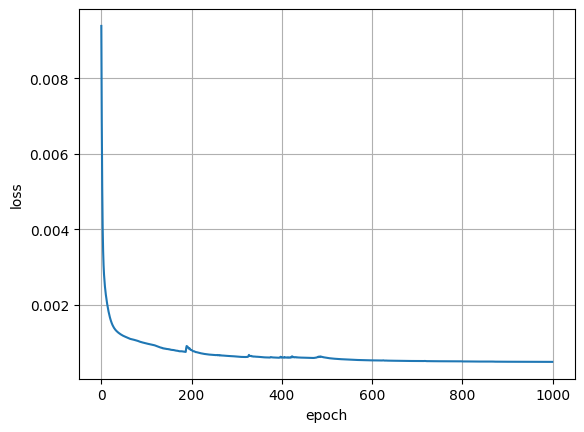

In [9]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.plot(losses);

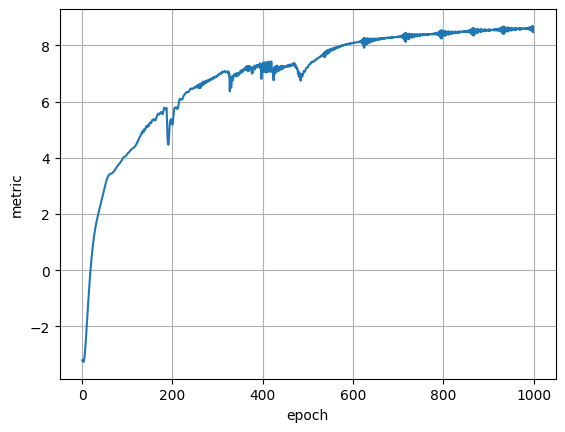

In [10]:
plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.plot(metrics);

In [11]:
spec_sample = stft.stft(train_sample[None])
mag = spec_sample.abs()
phase = th.atan2(spec_sample.imag, spec_sample.real)

mask = model_mask(spec_sample)
mag_predict = mag * mask

imag = mag_predict * th.sin(phase)
real = mag_predict * th.cos(phase)

z = th.complex(real, imag)

predict = stft.istft(z, train_sample.shape[-1])

In [12]:
Audio(predict[0].detach(), rate=16000)

In [13]:
Audio(train_target, rate=16000)

In [14]:
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

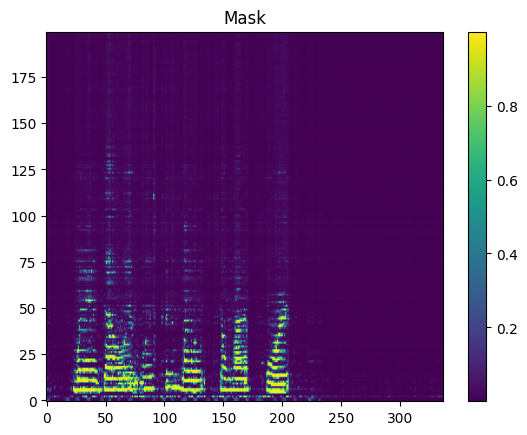

In [15]:
plot_mask(mask.detach()[0])

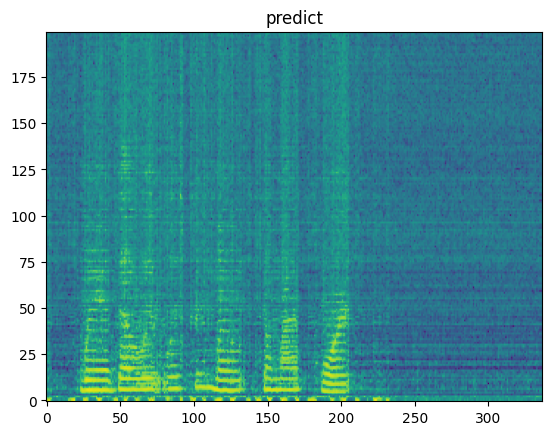

In [16]:
plt.title('predict')
plt.imshow(torch.log(mag_predict).detach()[0][0], cmap="viridis", origin="lower", aspect="auto");

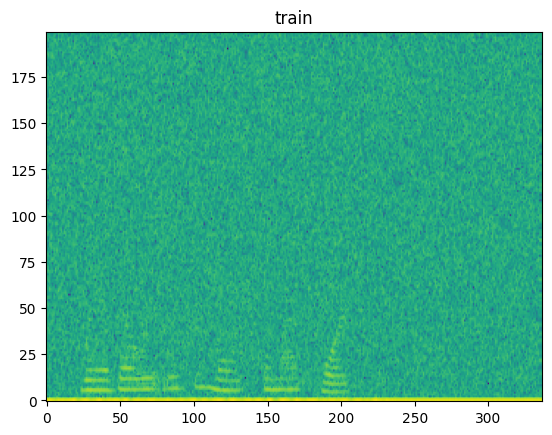

In [17]:
plt.title('train')
plt.imshow(torch.log(stft.stft(train_sample).abs()).detach()[0], cmap="viridis", origin="lower", aspect="auto");

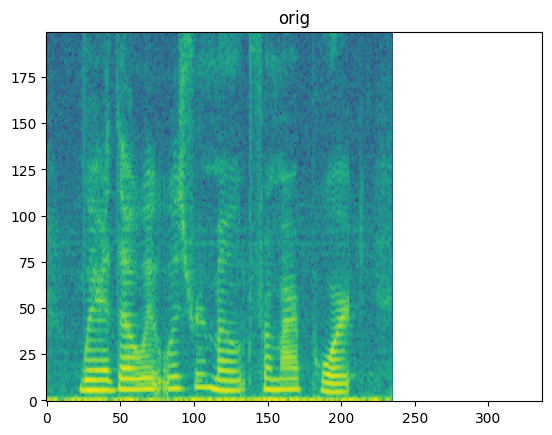

In [18]:
plt.title('orig')
plt.imshow(torch.log(stft.stft(train_target).abs()).detach()[0], cmap="viridis", origin="lower", aspect="auto");